# Demonstrate digital heterodyne detection

In [1]:
import matplotlib.pyplot as plt
from matplotlib import cm
import cvxpy as cp

import numpy as np

from qutip import *
from joblib import Parallel, delayed
from matplotlib import ticker
import matplotlib as mpl
import seaborn as sns

## Define operators

In [2]:
N=15

idc = qeye(N)
ida = qeye(2)

a  = tensor(destroy(N), ida)
sm = tensor(idc, destroy(2)) # note that this is not qutip's sigmam() definition

sx = tensor(idc, sigmax())
sy = tensor(idc, sigmay())
sz = tensor(idc, sigmaz())

proj0 = tensor(idc, basis(2,0).proj())
proj1 = tensor(idc, basis(2,1).proj())

In [3]:
def interact(g):
    op =   g * (a.dag() * sm - a * sm.dag())
    return op.expm() 

def rotateX(theta):
    op = (-1j) * (theta/2) * sx
    return op.expm()

def rotateY(theta):
    op = (-1j) * (theta/2) * sy
    return op.expm()

def rotateXY(theta,rotangl):
    op = (-1j) * (theta/2) * (np.cos(rotangl)* sx + np.sin(rotangl)* sy)
    return op.expm()

def interact(g):
    op = (-1j) * g * (a.dag() * sm + a * sm.dag())
    return op.expm() 

def H_int(g, dt):
    Hint =  (-1j) *g*np.sqrt(dt) * (a.dag() * sm + a * sm.dag())
    return Hint.expm()

def U_swap(gint):
    H_int =  (-1j) *gint * (a.dag() * sm + a * sm.dag())
    return H_int.expm()

In [4]:
# basis vectors for tomography later
# construct vectors
basis_vectors = []
for i in range(N):
    vector = fock(N, i)
    basis_vectors.append(np.real(vector.full()))
    
# construct operators
basis_dms = []
for vector1 in basis_vectors:
    for vector2 in basis_vectors:
        dm = np.outer(vector1, vector2)
        basis_dms.append(dm)

## Params

In [5]:
# number of trajectories
Ntrajs = 10000

# interaction strength
g = 0.3
delta_t = 0.3
dt = delta_t

gamma = g**2

gint = np.sqrt(gamma*delta_t)


alpha=2


N_cav = num(N)

#psi0 = (tensor(fock(N, 1), basis(2,0)) + tensor(fock(N, 2), basis(2,0))).unit()


gint = 0.1*np.pi/2
gamma = gint**2/dt

In [6]:
initial_cavity = (coherent(N, alpha) + coherent(N,-alpha)).unit()
             
Nmeas = 300

## Implements heterodyne detection

In [7]:
# generate interaction Hamiltonian with strength gint
U_int = U_swap(gint)

In [8]:
qbrotmat = [rotateXY(np.pi/2,0),rotateXY(np.pi/2,np.pi/2)] # # qb rotation applied prior to qb measurement. [rotate to X, rotate to Y]
qbfeedback = rotateX(np.pi) # this pulse will reset the qubit if found in the excited state

quadmeas = []

#  interleaving measurements of X and Y on the qubit
def get_heterodyne_meas(initial_cavity, Nmeas, seed):

    nsteps = np.linspace(0,Nmeas-1,Nmeas)
    weights=np.exp(-nsteps*(gamma*delta_t/2))
    weights =  np.sqrt(2*gamma*dt)*np.exp(-nsteps*(gint**2/2))
    Neach = round(Nmeas/2)
    
    results =[[] for i in range(2)]
    psi0 = tensor(initial_cavity, basis(2,0))
    psi = psi0

    prng = np.random.RandomState(seed)
    xrnd = prng.rand(Nmeas)
    # individual qubit measurements
    for i in range(Nmeas):
        k = i % 2 # do X and Y every other round
        
        psi = qbrotmat[k] * (U_int * psi)        
        prob = expect(proj0,psi)
        
        if prob > xrnd[i]:
            # measured g
            results[k].append(-1)
            psi = (proj0 * psi).unit()
        else:
            # measured e
            results[k].append(1)
            psi = (proj1 * psi).unit()
            # go back to g
            psi = qbfeedback * psi

    #return np.sum(results[1]*weights) + 1j * np.sum(results[0]*weights)
    return np.sum(results[1]*weights[::2]) + 1j * np.sum(results[0]*weights[1::2])

In [9]:
alpha=2
initial_cavity_cat = (coherent(N, alpha) + coherent(N,-alpha)).unit()

#set seed for reproducible results. Otherwise it may vary a little bit depending on the random measurement results.
np.random.seed(8888)
seeds = np.random.randint(1e8, size=Ntrajs)

# NOTE: do NOT use backend multiprocessing here, it doesn't deal with xrnd = np.random.rand(Nmeas) properly
quadmeas_cat = Parallel(n_jobs=-1, verbose=1, backend="loky")(delayed(get_heterodyne_meas)(initial_cavity_cat, Nmeas, seed) for seed in seeds)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done 736 tasks      | elapsed:    8.8s
[Parallel(n_jobs=-1)]: Done 1186 tasks      | elapsed:   12.3s
[Parallel(n_jobs=-1)]: Done 1736 tasks      | elapsed:   16.6s
[Parallel(n_jobs=-1)]: Done 2386 tasks      | elapsed:   21.7s
[Parallel(n_jobs=-1)]: Done 3136 tasks      | elapsed:   27.6s
[Parallel(n_jobs=-1)]: Done 3986 tasks      | elapsed:   34.3s
[Parallel(n_jobs=-1)]: Done 4936 tasks      | elapsed:   41.7s
[Parallel(n_jobs=-1)]: Done 5986 tasks      | elapsed:   49.9s
[Parallel(n_jobs=-1)]: Done 7136 tasks      | elapsed:   58.9s
[Parallel(n_jobs=-1)]: Done 8386 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 9736 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 10000 out of 10000 | elapsed:  1.4min finished


In [10]:
k=5 # phase space outer limit
Nbins=30

xvec = np.linspace(-k,k,Nbins)
Q_comp_cat = qfunc(initial_cavity_cat, xvec, xvec) # ideal Q-function

real_meas_cat = np.real(np.array(quadmeas_cat))
imag_meas_cat = np.imag(np.array(quadmeas_cat))

hist_cat, xedges, yedges = np.histogram2d(real_meas_cat, imag_meas_cat, Nbins,range=[[-k,k],[-k,k]],normed=True)

### Tomographic reconstruction

[Parallel(n_jobs=16)]: Using backend MultiprocessingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 1248 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 194639 tasks      | elapsed:    2.4s
[Parallel(n_jobs=16)]: Done 202500 out of 202500 | elapsed:    2.5s finished


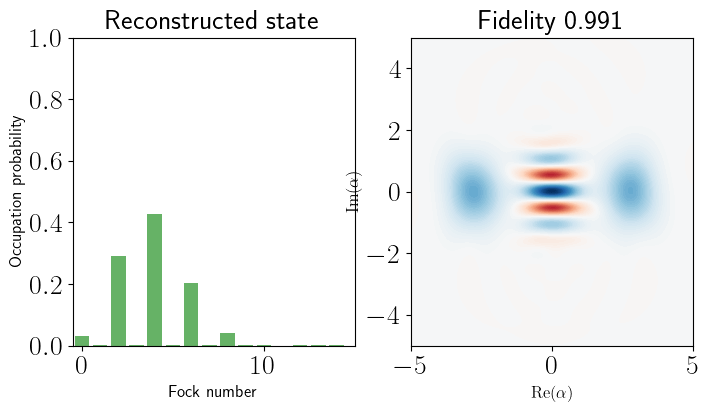

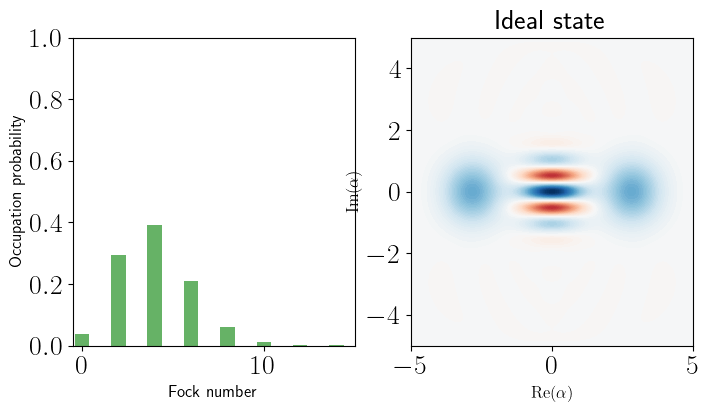

In [11]:
hist = hist_cat
b=hist.flatten()


def qfunc_ops(hilbert_size, beta):
    
    # need the larger Hilbert space to not get erroneous operators for large beta
    # scaling corresponding to x = (a + adag) / sqrt(2)
    op = coherent_dm(50, beta/np.sqrt(2))/np.pi/2
    op = Qobj(op[:hilbert_size, :hilbert_size]) # truncate to wanted Hilbert space size
        
    return op


# Use midpoint of grid as phase space points
xvec2 = []
for idx, x in enumerate(xedges[:-1]):
    xvec2.append((x + xedges[idx+1])/2)

yvec2 = []
for idx, y in enumerate(yedges[:-1]):
    yvec2.append((y + yedges[idx+1])/2)
   

xvec = xvec2
yvec = yvec2
X, Y = np.meshgrid(xvec, yvec)
betas = (X + 1j*Y).ravel()

Pis = Parallel(n_jobs=-1, verbose=0, backend="multiprocessing")(delayed(qfunc_ops)(N,beta) for beta in betas)

def func(index, a):
    return np.trace(Pis[index[0]].full() @ basis_dms[index[1]])

A = np.zeros((len(Pis), N*N), dtype=np.complex64)
A_p = Parallel(n_jobs=16, verbose=1, backend="multiprocessing")(delayed(func)(idx,a) for idx, a in np.ndenumerate(A))

A = np.reshape(A_p, (len(Pis), N*N))

# Define the unknown state as a $N\times N$ Hermitian matrix

X = cp.Variable((N,N), hermitian=True)

#Set the cost function to $\|A\vec\rho - \vec b\|_2$ where the vectorized state is given by `cp.vec(X)`.

cost = cp.norm(A @ cp.vec(X) - b, 2) 

#Set the trace constraint and positive-semidefinite constraint, respectively.
constraints = [cp.trace(X) == 1, X >> 0 ]

#Set up and solve the problem!

prob = cp.Problem(cp.Minimize(cost), constraints)
prob.solve(verbose=False, solver='SCS')

# Assign the optimized state X to a Qobj.
reconstructed_rho = Qobj(X.value)

### Visualize results

#Plot the reconstructed state 
alpha_max = 5
fig, ax = plot_wigner_fock_distribution(reconstructed_rho, alpha_max=5)
ax[0].set_title("Reconstructed state")

f_cat=fidelity(reconstructed_rho, initial_cavity_cat)**2
ax[1].set_title("Fidelity %.3f"%(f_cat));

plot_wigner_fock_distribution(initial_cavity_cat, alpha_max=5)
plt.title("Ideal state");

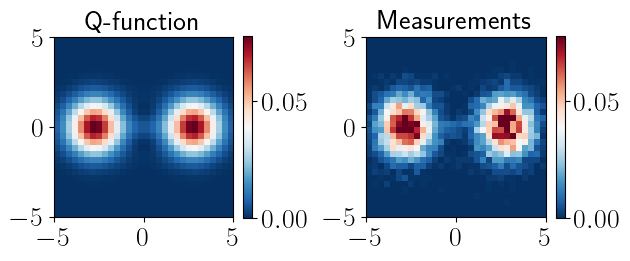

In [12]:
fig, ax = plt.subplots(1,2)
vmax = np.max(Q_comp_cat)
vmin=0

fig1 = ax[0].imshow(Q_comp_cat,extent=[-k,k,-k,k], cmap=cm.RdBu_r, vmin=vmin, vmax=vmax)
cb = plt.colorbar(fig1, ax=ax[0], fraction=0.046)
#cb.set_ticks([0.0, 0.05, 0.1, 0.15])
ax[0].set_title('Q-function')

fig2=ax[1].imshow(hist_cat, extent=[-k,k,-k,k], cmap=cm.RdBu_r, vmin=vmin, vmax=vmax)
cb = plt.colorbar(fig2, ax=ax[1], fraction=0.046)
#cb.set_ticks([0.0, 0.05, 0.1, 0.15])
#tick_locator = ticker.MaxNLocator(nbins=6)
#cb.locator = tick_locator
#cb.update_ticks()
ax[1].set_title('Measurements');
plt.tight_layout()

## Coherent

In [13]:
alpha=2
initial_cavity_coherent = coherent(N, alpha)

#set seed for reproducible results. Otherwise it may vary a little bit depending on the random measurement results.
np.random.seed(8888)
seeds = np.random.randint(1e8, size=Ntrajs)

# NOTE: do NOT use backend multiprocessing here, it doesn't deal with xrnd = np.random.rand(Nmeas) properly
quadmeas_coherent = Parallel(n_jobs=-1, verbose=1, backend="loky")(delayed(get_heterodyne_meas)(initial_cavity_coherent, Nmeas, seed) for seed in seeds)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 736 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done 1186 tasks      | elapsed:    9.6s
[Parallel(n_jobs=-1)]: Done 1736 tasks      | elapsed:   13.9s
[Parallel(n_jobs=-1)]: Done 2386 tasks      | elapsed:   19.0s
[Parallel(n_jobs=-1)]: Done 3136 tasks      | elapsed:   24.8s
[Parallel(n_jobs=-1)]: Done 3986 tasks      | elapsed:   31.5s
[Parallel(n_jobs=-1)]: Done 4936 tasks      | elapsed:   39.0s
[Parallel(n_jobs=-1)]: Done 5986 tasks      | elapsed:   47.2s
[Parallel(n_jobs=-1)]: Done 7136 tasks      | elapsed:   56.2s
[Parallel(n_jobs=-1)]: Done 8386 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 9736 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 10000 out of 10000 | elapsed:  1.3min finished


[Parallel(n_jobs=16)]: Using backend MultiprocessingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 1248 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 133088 tasks      | elapsed:    2.2s
[Parallel(n_jobs=16)]: Done 202500 out of 202500 | elapsed:    2.8s finished


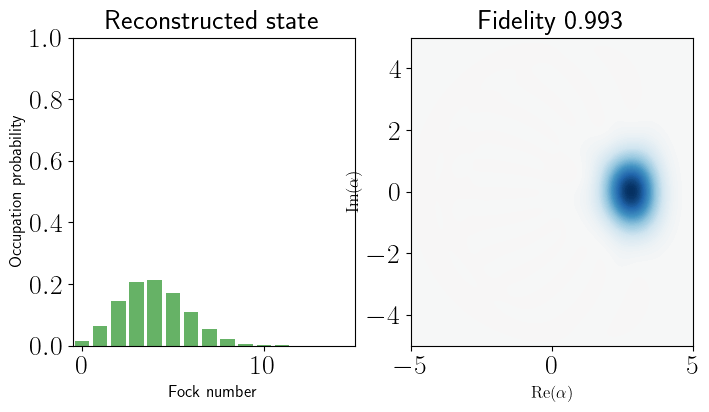

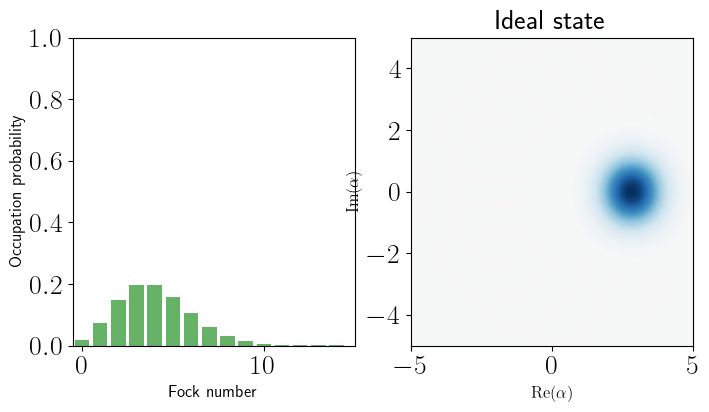

In [14]:
xvec = np.linspace(-k,k,Nbins)
Q_comp_coherent = qfunc(initial_cavity_coherent, xvec, xvec) # ideal Q-function

real_meas_coherent = np.real(np.array(quadmeas_coherent))
imag_meas_coherent = np.imag(np.array(quadmeas_coherent))

hist_coherent, xedges, yedges = np.histogram2d(real_meas_coherent, imag_meas_coherent, Nbins,range=[[-k,k],[-k,k]],normed=True)

hist = hist_coherent
b=hist.flatten()

xvec2 = []
for idx, x in enumerate(xedges[:-1]):
    xvec2.append((x + xedges[idx+1])/2)
yvec2 = []
for idx, y in enumerate(yedges[:-1]):
    yvec2.append((y + yedges[idx+1])/2)

xvec = xvec2
yvec = yvec2
X, Y = np.meshgrid(xvec, yvec)
betas = (X + 1j*Y).ravel()

Pis = Parallel(n_jobs=-1, verbose=0, backend="multiprocessing")(delayed(qfunc_ops)(N,beta) for beta in betas)

def func(index, a):
    return np.trace(Pis[index[0]].full() @ basis_dms[index[1]])
A = np.zeros((len(Pis), N*N), dtype=np.complex64)
A_p = Parallel(n_jobs=16, verbose=1, backend="multiprocessing")(delayed(func)(idx,a) for idx, a in np.ndenumerate(A))
A = np.reshape(A_p, (len(Pis), N*N))

X = cp.Variable((N,N), hermitian=True)
cost = cp.norm(A @ cp.vec(X) - b, 2) 
constraints = [cp.trace(X) == 1, X >> 0 ]
prob = cp.Problem(cp.Minimize(cost), constraints)
prob.solve(verbose=False, solver='SCS')
reconstructed_rho_coherent = Qobj(X.value)
 
alpha_max = 5
fig, ax = plot_wigner_fock_distribution(reconstructed_rho_coherent, alpha_max=5)
ax[0].set_title("Reconstructed state")

f_coherent=fidelity(reconstructed_rho_coherent, initial_cavity_coherent)**2
ax[1].set_title("Fidelity %.3f"%(f_coherent));

plot_wigner_fock_distribution(initial_cavity_coherent, alpha_max=5)
plt.title("Ideal state");

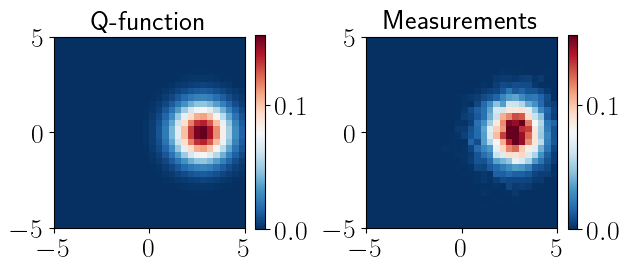

In [15]:
fig, ax = plt.subplots(1,2)
vmax = np.max(Q_comp_coherent)
vmin=0

fig1 = ax[0].imshow(Q_comp_coherent,extent=[-k,k,-k,k], cmap=cm.RdBu_r, vmin=vmin, vmax=vmax)
ax[0].set_title('Q-function')
cb1 = plt.colorbar(fig1, ax=ax[0], fraction=0.046)
#cb1.set_ticks([0.0, 0.1, 0.2, 0.3])


fig2=ax[1].imshow(hist_coherent, extent=[-k,k,-k,k], cmap=cm.RdBu_r, vmin=vmin, vmax=vmax)
ax[1].set_title('Measurements');
cb = plt.colorbar(fig2, ax=ax[1], fraction=0.046)

#cb.set_ticks([0.0, 0.1, 0.2, 0.3])
#tick_locator = ticker.MaxNLocator(nbins=4)
#cb.locator = tick_locator
#cb.update_ticks()

plt.tight_layout()

## Fock

In [16]:
initial_cavity_fock = fock(N,2)
k_fock=3.5

In [17]:
#set seed for reproducible results. Otherwise it may vary a little bit depending on the random measurement results.
np.random.seed(8888)

seeds = np.random.randint(1e8, size=Ntrajs)

# NOTE: do NOT use backend multiprocessing here, it doesn't deal with xrnd = np.random.rand(Nmeas) properly
quadmeas_fock = Parallel(n_jobs=-1, verbose=1, backend="loky")(delayed(get_heterodyne_meas)(initial_cavity_fock, Nmeas, seed) for seed in seeds)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 736 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done 1186 tasks      | elapsed:    9.5s
[Parallel(n_jobs=-1)]: Done 1736 tasks      | elapsed:   13.7s
[Parallel(n_jobs=-1)]: Done 2386 tasks      | elapsed:   18.8s
[Parallel(n_jobs=-1)]: Done 3136 tasks      | elapsed:   24.6s
[Parallel(n_jobs=-1)]: Done 3986 tasks      | elapsed:   31.4s
[Parallel(n_jobs=-1)]: Done 4936 tasks      | elapsed:   39.0s
[Parallel(n_jobs=-1)]: Done 5986 tasks      | elapsed:   47.2s
[Parallel(n_jobs=-1)]: Done 7136 tasks      | elapsed:   56.3s
[Parallel(n_jobs=-1)]: Done 8386 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 9736 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 10000 out of 10000 | elapsed:  1.3min finished


[Parallel(n_jobs=16)]: Using backend MultiprocessingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 1248 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 194639 tasks      | elapsed:    2.8s
[Parallel(n_jobs=16)]: Done 202500 out of 202500 | elapsed:    2.9s finished


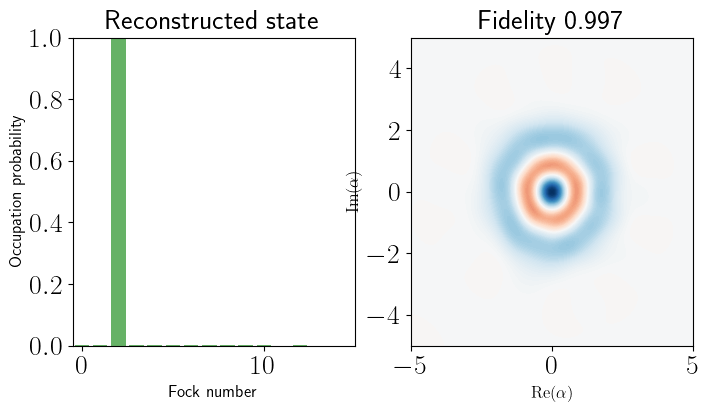

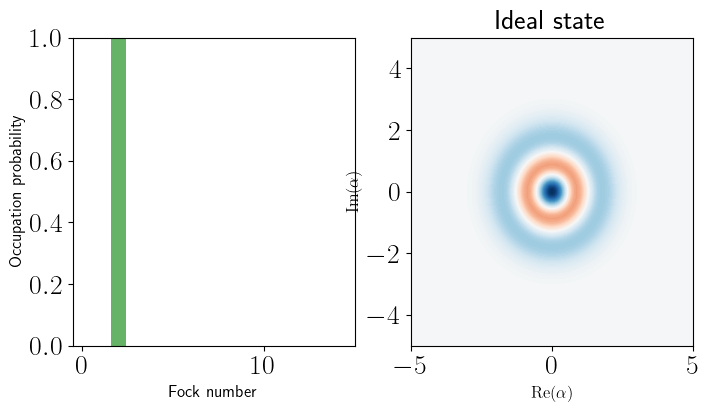

In [18]:
xvec = np.linspace(-k_fock,k_fock,Nbins)
Q_comp_fock = qfunc(initial_cavity_fock, xvec, xvec) # ideal Q-function

real_meas_fock = np.real(np.array(quadmeas_fock))
imag_meas_fock = np.imag(np.array(quadmeas_fock))

hist_fock, xedges, yedges = np.histogram2d(real_meas_fock, imag_meas_fock, Nbins,range=[[-k_fock,k_fock],[-k_fock,k_fock]],normed=True)

hist = hist_fock
b=hist.flatten()

xvec2 = []
for idx, x in enumerate(xedges[:-1]):
    xvec2.append((x + xedges[idx+1])/2)
yvec2 = []
for idx, y in enumerate(yedges[:-1]):
    yvec2.append((y + yedges[idx+1])/2)

xvec = xvec2
yvec = yvec2
X, Y = np.meshgrid(xvec, yvec)
betas = (X + 1j*Y).ravel()

Pis = Parallel(n_jobs=-1, verbose=0, backend="multiprocessing")(delayed(qfunc_ops)(N,beta) for beta in betas)

def func(index, a):
    return np.trace(Pis[index[0]].full() @ basis_dms[index[1]])
A = np.zeros((len(Pis), N*N), dtype=np.complex64)
A_p = Parallel(n_jobs=16, verbose=1, backend="multiprocessing")(delayed(func)(idx,a) for idx, a in np.ndenumerate(A))
A = np.reshape(A_p, (len(Pis), N*N))

X = cp.Variable((N,N), hermitian=True)
cost = cp.norm(A @ cp.vec(X) - b, 2) 
constraints = [cp.trace(X) == 1, X >> 0 ]
prob = cp.Problem(cp.Minimize(cost), constraints)
prob.solve(verbose=False, solver='SCS')
reconstructed_rho_fock = Qobj(X.value)
 
alpha_max = 5
fig, ax = plot_wigner_fock_distribution(reconstructed_rho_fock, alpha_max=5)
ax[0].set_title("Reconstructed state")

f_fock=fidelity(reconstructed_rho_fock, initial_cavity_fock)**2
ax[1].set_title("Fidelity %.3f"%(f_fock));

plot_wigner_fock_distribution(initial_cavity_fock, alpha_max=5)
plt.title("Ideal state");

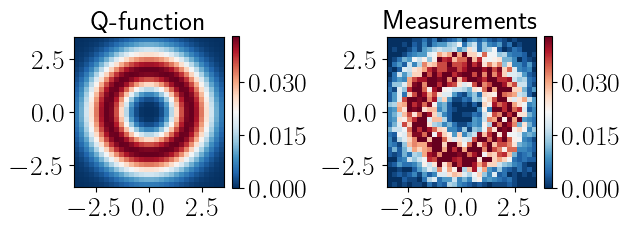

In [19]:
fig, ax = plt.subplots(1,2)
vmax = np.max(Q_comp_fock)
vmin=0

fig1 = ax[0].imshow(Q_comp_fock,extent=[-k_fock,k_fock,-k_fock,k_fock], cmap=cm.RdBu_r, vmin=vmin, vmax=vmax)
ax[0].set_title('Q-function')
cb1 = plt.colorbar(fig1, ax=ax[0], fraction=0.046)
tick_locator = ticker.MaxNLocator(nbins=4)
cb1.locator = tick_locator
cb1.update_ticks()

fig2=ax[1].imshow(hist_fock, extent=[-k_fock,k_fock,-k_fock,k_fock], cmap=cm.RdBu_r, vmin=vmin, vmax=vmax)
cb = plt.colorbar(fig2, ax=ax[1], fraction=0.046)
ax[1].set_title('Measurements');
#cb.set_ticks([0.0, 0.085])
cb.locator = tick_locator
cb.update_ticks()
plt.tight_layout()

# Plot

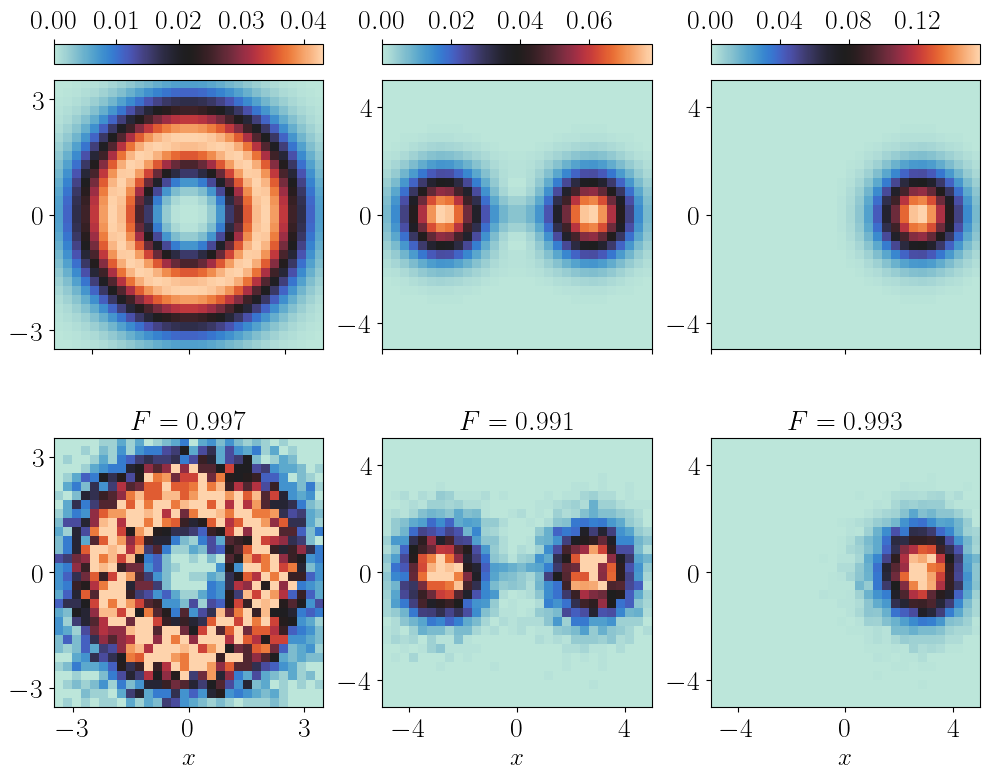

In [20]:
fig, ax = plt.subplots(3,3, figsize=(10,8), gridspec_kw={"width_ratios":[1,1,1], "height_ratios":[0.05, 1,1]})
vmax_fock = np.max(Q_comp_fock)
vmin=0

cmap=sns.color_palette("icefire", as_cmap=True)

#cmap =sns.color_palette("blend:#EDA,#7AB", as_cmap=True)

#cmap=sns.cubehelix_palette(start=-0.1, rot=1, as_cmap=True)


fig1 = ax[1,0].imshow(Q_comp_fock,extent=[-k_fock,k_fock,-k_fock,k_fock], cmap=cmap, vmin=vmin, vmax=vmax_fock)
fig2=ax[2,0].imshow(hist_fock, extent=[-k_fock,k_fock,-k_fock,k_fock], cmap=cmap, vmin=vmin, vmax=vmax_fock)
ax[1,0].xaxis.set_tick_params(labelbottom=False)
ax[1,0].set_yticks([-3, 0, 3])
ax[2,0].set_xticks([-3, 0, 3])
ax[2,0].set_yticks([-3, 0, 3])

cb1 = fig.colorbar(fig2, cax=ax[0,0], orientation = 'horizontal')
tick_locator = ticker.MaxNLocator(nbins=5)
cb1.locator = tick_locator
cb1.update_ticks()

ax[0,0].xaxis.set_label_position('top')
ax[0,0].xaxis.set_ticks_position('top')

ax[2,0].set_title('$F=%.3f$'%np.round(f_fock,3))

vmax_cat = np.max(Q_comp_cat)

fig1 = ax[1,1].imshow(Q_comp_cat,extent=[-k,k,-k,k], cmap=cmap, vmin=vmin, vmax=vmax_cat)
fig2=ax[2,1].imshow(hist_cat, extent=[-k,k,-k,k], cmap=cmap, vmin=vmin, vmax=vmax_cat)
cb = fig.colorbar(fig2, cax=ax[0,1], orientation = 'horizontal')

ax[0,1].xaxis.set_label_position('top')
ax[0,1].xaxis.set_ticks_position('top')
#cb.set_ticks([0.0, 0.035, 0.07])
tick_locator = ticker.MaxNLocator(nbins=4)
cb.locator = tick_locator
cb.update_ticks()

ax[1,1].xaxis.set_tick_params(labelbottom=False)
ax[2,1].set_xticks([-4, 0,4])
#ax[1,1].set_xticks([-3, 0, 3])
ax[1,1].set_yticks([-4, 0,4])
ax[2,1].set_yticks([-4, 0,4])
vmax_coherent = np.max(Q_comp_coherent)
ax[2,1].set_title('$F=%.3f$'%np.round(f_cat,3))

fig1 = ax[1,2].imshow(Q_comp_coherent,extent=[-k,k,-k,k], cmap=cmap, vmin=vmin, vmax=vmax_coherent)
fig2=ax[2,2].imshow(hist_coherent, extent=[-k,k,-k,k], cmap=cmap, vmin=vmin, vmax=vmax_coherent)
cb = fig.colorbar(fig2, cax=ax[0,2], orientation='horizontal')
ax[0,2].xaxis.set_label_position('top')
ax[0,2].xaxis.set_ticks_position('top')
ax[2,2].set_title('$F=%.3f$'%np.round(f_coherent,3))
#cb.set_ticks([0.0, 0.1, 0.2, 0.3])
tick_locator = ticker.MaxNLocator(nbins=4)
cb.locator = tick_locator
cb.update_ticks()

ax[1,2].xaxis.set_tick_params(labelbottom=False)
#ax[0,2].set_yticks([-3, 0, 3])
ax[1,2].set_yticks([-4, 0,4])
ax[2,2].set_xticks([-4, 0,4])
ax[2,2].set_yticks([-4, 0,4])
ax[2,2].set_xlabel('$x$')
ax[2,1].set_xlabel('$x$')
ax[2,0].set_xlabel('$x$')
fig.set_constrained_layout_pads(w_pad=0.1, h_pad=-0.5, wspace=0., hspace=-0.5)
fig.subplots_adjust(wspace = 0.4, hspace=-0.2)
plt.tight_layout()
#plt.savefig('heterodyne_states_fidelitites_rescaled.pdf')

## Test KS stats

In [21]:
#Use more points to get more ideal Q-function to compare with
n=1000
xvec = np.linspace(-k,k,n)

Q_comp_coherent = qfunc(coherent(N,2), xvec, xvec) # ideal Q-function
Q_comp_fock = qfunc(fock(N,2), xvec, xvec) # ideal Q-function
Q_comp_cat = qfunc((coherent(N, alpha) + coherent(N,-alpha)).unit(), xvec, xvec) 

In [ ]:
# Original function from Numerical Recipes in C, Chapter 14.7 
"""
Counts points in the four quadrants around a point (x,p)
Given an origin (x, y), and an array of nn points with coordinates xx[1..nn] and yy[1..nn],
count how many of them are in each quadrant around the origin, and return the normalized
fractions. Quadrants are labeled alphabetically, counterclockwise from the upper right. Used
by ks2d1s and ks2d1s.
"""
def quadct(x, y, xvec, yvec):
    nn = len(yvec)

    na = 0; nb = 0; nc = 0; nd = 0

    for k in range(0,nn):
        #print(yvec[k], y)
        if yvec[k] > y:
            if (xvec[k] > x): 
                na += 1 
            else: 
                nb += 1
        else:
            if (xvec[k] > x): 
                nd += 1 
            else: 
                nc += 1
            
    ff = 1/nn

    fa = ff*na
    fb = ff*nb
    fc = ff*nc
    fd = ff*nd
    return fa, fb, fc, fd


def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

# Original function from Numerical Recipes in C, Chapter 14.7 
"""
the integrated probability of an analytic model in each of four quadrants around an arbitrary (x, y) point. 

this routine should return, for any point (x, y), the fraction of the total distribution in each of the four
quadrants around that point. The fractions, fa, fb, fc , and fd, must add up to 1.
Quadrants are labeled alphabetically, counterclockwise from the upper right. 
"""
def quadv1(x1, y1, q_func, xvec, yvec):
    x_idx = find_nearest(y1, xvec) 
    y_idx= find_nearest(x1, yvec)
    x_idx = len(xvec)-x_idx
    # x1 and y1 are switched on purpose, that and the final subtraction corresponds to the correct coordinates
    # obtained via manual plotting and testing...

    ga = np.sum(q_func[:x_idx, y_idx:]) /np.sum(q_func)
    gb = np.sum(q_func[:x_idx, :y_idx]) /np.sum(q_func)
    gc = np.sum(q_func[x_idx:, :y_idx]) /np.sum(q_func)
    gd = np.sum(q_func[x_idx:, y_idx:]) /np.sum(q_func)
    return ga, gb, gc, gd

# Original function from Numerical Recipes in C, Chapter 14.7 
"""
Two-dimensional Kolmogorov-Smirnov test of one sample against a model. Given the x and y
coordinates of n1 data points in arrays x1[1..n1] and y1[1..n1], and given a user-supplied
function quadvl that exemplifies the model, this routine returns the two-dimensional K-S
statistic as d1
"""
def ks2d1s(x1vec, y1vec, q_func, xvec, yvec):
    n = len (x1vec)
    n1=n
    n2=n

    d1 = 0
    for j in range(0, n1):
        fa, fb, fc, fd = quadct(x1vec[j], y1vec[j], x1vec, y1vec)
        ga, gb ,gc, gd = quadv1(x1vec[j], y1vec[j],q_func, xvec, xvec)
        d1 = max(d1,abs(fa-ga))
        d1 = max(d1, abs(fb - gb))
        d1 = max(d1, abs(fc - gc))
        d1 = max(d1, abs(fd - gd))       
    return d1

# have a lot of samples, only use every tenth to speed up calculation.
t = 10

d_fock = ks2d1s(real_meas_fock[::t], imag_meas_fock[::t], Q_comp_fock, xvec, xvec)
d_coherent = ks2d1s(real_meas_coherent[::t], imag_meas_coherent[::t], Q_comp_coherent, xvec, xvec)
d_cat = ks2d1s(real_meas_cat[::t], imag_meas_cat[::t], Q_comp_cat, xvec, xvec)

print('Fock: %.3f, Coherent: %.3f, Cat: %.3f '%(d_fock, d_coherent, d_cat))